<a href="https://colab.research.google.com/github/ahlqui/VeloxChemColabs/blob/main/UV_Vis_spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Calculate UV/Vis spectrum using TDDFT


This notebook requires that you have a molecular structure. Two options:

Define Molecule as XYZ-coordinates: Can be generatred with free software such as www.avogadro.cc

Define Molecule with SMILES code, A molecule can be defined using a SMILES code (example below). We have two suggested ways to generate smiles from structure. 1) Sketch your molecule at https://www.rcsb.org/chemical-sketch and the SMILES code will be shown right below the structure. 2) Build your molecule at https://molview.org/ , go to Tools/Information Card and it will show you the SMILES code. Just copy/paste it into the SMILES box below.

Example of xyz-coordinates for CO2:

O 0.00 0.00 0.00

C 0.00 0.00 1.20

O 0.00 0.00 2.40

Example of SMILES for CO2:

O=C=O

In [1]:
#@title Install VeloxChem and dependencies (ca 2 min)
#@markdown Before you can run anything a few things need to be installed. It all runs on the Google Colab server an you do not need to install anything on your computer.
%%capture
import sys

! wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh
! bash Miniforge3-Linux-x86_64.sh -bfp /usr/local
! mamba config --set auto_update_conda false
import sys
sys.path.append('/usr/local/lib/python3.11/site-packages/')
!mamba install -y -c conda-forge -c veloxchem veloxchem  py3Dmol dftd4-python  matplotlib python=3.11
! pip install rdkit
import veloxchem as vlx

In [2]:
xyz_coordinates = """
N             -1.081185000000        -0.426329000000         2.615032000000
C             -0.862538000000        -1.492772000000         1.642987000000
C             -1.081833000000        -0.962619000000         0.220708000000
C             -0.911054000000        -2.056441000000        -0.841632000000
C              0.512948000000        -2.508082000000        -0.950749000000
O              1.350213000000        -1.809455000000        -1.582309000000
O              0.917599000000        -3.684353000000        -0.327457000000
H             -2.103462000000        -0.204758000000         2.633406000000
H             -0.843547000000        -0.804304000000         3.560687000000
H              0.180186000000        -1.864615000000         1.745142000000
H             -1.559953000000        -2.336224000000         1.847076000000
H             -2.115284000000        -0.559803000000         0.142810000000
H             -0.376464000000        -0.126528000000         0.018522000000
H             -1.563687000000        -2.924153000000        -0.603270000000
H             -1.235575000000        -1.656122000000        -1.826437000000
H              1.879945000000        -3.996010000000        -0.381026000000
"""


In [3]:
#@title Define your molecule, either asa SMILES code or xyz-coordinates above
#@markdown - Enter the SMILES code
import veloxchem as vlx
smiles_code = 'OCCC=O' #@param {type:"string"}
#@markdown - If you want to use the xyz coordinates in the previous cell check box
use_xyz = True # @param {type:"boolean"}
if use_xyz == False:
  molecule = vlx.Molecule.read_smiles(smiles_code)
else:
  molecule = vlx.Molecule.read_str(xyz_coordinates)
print('Structure of the molecule entered: ')
molecule.show(atom_indices=True)
#@markdown - Give your Gromacs files a name
gromacs_file = 'test' #@param {type:"string"}
#@markdown - Give your molecule a residue name (three letters)
residue_name = 'tes' #@param {type:"string"}



Structure of the molecule entered: 


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
#@title DFT optimization of the geometry
#@markdown Example timing: GABA 10 steps 2 minutes
basis = vlx.MolecularBasis.read(molecule, 'def2-sv(p)')
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.xcfun = 'BLYP'
scf_drv.dispersion = True
scf_drv.conv_thresh = 1e-3
scf_drv.grid_level = 2
scf_drv.ri_coulomb = True
scf_drv.ostream.mute()
scf_results = scf_drv.compute(molecule, basis)


opt_drv = vlx.OptimizationDriver(scf_drv)
opt_drv.ostream.mute()
opt_steps = 10 #@param {type:"integer"}
opt_drv.max_iter = opt_steps
opt_drv.conv_maxiter = True
opt_results = opt_drv.compute(molecule, basis, scf_results)

final_geometry = vlx.Molecule.read_xyz_string(opt_results["final_geometry"])
final_geometry.show()
print('Energy of optimized structure: ' + str(opt_results["opt_energies"][-1]))
print('XYZ coordinates of optimized structure:')
print(opt_results["final_geometry"])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Energy of optimized structure: -362.6465330676251
XYZ coordinates of optimized structure:
16

N             -1.143948819631        -0.521440553613         2.593182829744
C             -0.935141398202        -1.557951617130         1.570124924618
C             -1.267707870453        -1.001400317084         0.172838528220
C             -1.100314070483        -2.038425466850        -0.968333661433
C              0.348108383097        -2.491925836928        -1.079977609425
O              1.259069399468        -1.844706831486        -1.563772622003
O              0.544144727214        -3.723559761129        -0.510338571157
H             -2.148311553951        -0.291065413698         2.663080599750
H             -0.865516700403        -0.873905720516         3.521278637985
H              0.137134571028        -1.852965024330         1.605125481415
H             -1.521145882239        -2.503652055013         1.731672244385
H             -2.322947617906        -0.642804721587         0.1633347

In [14]:
#@title Visualize the optimization
opt_drv.show_convergence(opt_results)

interactive(children=(IntSlider(value=10, description='step', max=10), Output()), _dom_classes=('widget-intera…

In [15]:
#@title TDDFT to generate UV/Vis spectrum
#@markdown Example timing: GABA 13 minutes
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol as p3d
import veloxchem as vlx
from matplotlib import gridspec
from scipy.interpolate import interp1d

# au to eV conversion factor
au2ev = 27.211386

molecule = vlx.Molecule.read_xyz_string(opt_results["final_geometry"])
basis_set = 'DEF2-SVP' #@param  ['6-31++G', '6-31++G*', '6-31++G**', '6-31+G', '6-31+G*', '6-31+G**', '6-311++G', '6-311++G(2D,2P)', '6-311++G(3DF,3PD)', '6-311++G*', '6-311++G**', '6-311+G', '6-311+G(2D,P)', '6-311+G*', '6-311+G**', '6-311G', '6-311G(2DF,2PD)', '6-311G*', '6-311G**', '6-31G', '6-31G(2DF,P)', '6-31G(3DF,3PD)', '6-31G*', '6-31G**', 'ANO-L-MB', 'ANO-L-VDZP', 'ANO-L-VQZP', 'ANO-L-VTZP', 'ANO-S-MB', 'ANO-S-VDZP', 'AO-START-GUESS', 'AUG-CC-PCV5Z', 'AUG-CC-PCVDZ', 'AUG-CC-PCVQZ', 'AUG-CC-PCVTZ', 'AUG-CC-PV5Z', 'AUG-CC-PV6Z', 'AUG-CC-PVDZ', 'AUG-CC-PVQZ', 'AUG-CC-PVTZ', 'AUG-PCSEG-0', 'AUG-PCSEG-1', 'AUG-PCSEG-2', 'AUG-PCSEG-3', 'AUG-PCSEG-4', 'AUG-PCX-1', 'AUG-PCX-2', 'AUG-PCX-3', 'AUG-PCX-4', 'CC-PCV5Z', 'CC-PCVDZ', 'CC-PCVQZ', 'CC-PCVTZ', 'CC-PV5Z', 'CC-PV6Z', 'CC-PVDZ', 'CC-PVQZ', 'CC-PVTZ', 'DAUG-CC-PCV5Z', 'DAUG-CC-PCVDZ', 'DAUG-CC-PCVQZ', 'DAUG-CC-PCVTZ', 'DAUG-CC-PV5Z', 'DAUG-CC-PV6Z', 'DAUG-CC-PVDZ', 'DAUG-CC-PVQZ', 'DAUG-CC-PVTZ', 'DEF2-QZVP', 'DEF2-QZVPD', 'DEF2-QZVPP', 'DEF2-QZVPPD', 'DEF2-SV(P)', 'DEF2-SVP', 'DEF2-SVPD', 'DEF2-TZVP', 'DEF2-TZVPD', 'DEF2-TZVPP', 'DEF2-TZVPPD', 'PCSEG-0', 'PCSEG-1', 'PCSEG-2', 'PCSEG-3', 'PCSEG-4', 'PCX-1', 'PCX-2', 'PCX-3', 'PCX-4', 'SADLEJ-PVTZ', 'STO-3G', 'STO-3G-OLD', 'STO-6G', 'TAUG-CC-PCV5Z', 'TAUG-CC-PCVDZ', 'TAUG-CC-PCVQZ', 'TAUG-CC-PCVTZ', 'TAUG-CC-PV5Z', 'TAUG-CC-PV6Z', 'TAUG-CC-PVDZ', 'TAUG-CC-PVQZ', 'TAUG-CC-PVTZ']
basis = vlx.MolecularBasis.read(molecule, basis_set)
scf_drv = vlx.ScfRestrictedDriver()
mute_output = True # @param {type:"boolean"}
if mute_output == True:
  scf_drv.ostream.mute()
else:
  scf_drv.ostream
functional = 'CAM-B3LYP' #@param ['SLATER', 'SLDA', 'B88X', 'BLYP', 'B3LYP', 'CAM-B3LYP', 'BHANDH', 'BHANDHLYP', 'PBE', 'PBE0', 'REVPBE', 'BP86', 'PW91', 'MPW1K', 'OLYP', 'O3LYP', 'X3LYP', 'B97', 'B97-1', 'B97-2', 'B97-3', 'TPSS', 'TPSSH', 'REVTPSS', 'PKZB', 'SCAN', 'RSCAN', 'R2SCAN', 'M05', 'M05-2X', 'M06', 'M06-2X', 'M06-HF', 'M06-L', 'M11-L', 'MPW1B95', 'MPWB1K', 'PW6B95', 'PWB6K']
scf_drv.xcfun = functional
scf_results = scf_drv.compute(molecule, basis)
print(f"DFT energy: {scf_drv.get_scf_energy():14.10f} a.u.")
method_settings = {"xcfun":functional}
rpa_solver = vlx.lreigensolver.LinearResponseEigenSolver()
mute_output_tddft = True # @param {type:"boolean"}
if mute_output_tddft == True:
  rpa_solver.ostream.mute()
else:
  rpa_solver.ostream
Number_of_excitations = 3 # @param {type:"integer"}
rpa_solver.update_settings({"nstates": Number_of_excitations}, method_settings)
rpa_results = rpa_solver.compute(molecule, basis, scf_results)




DFT energy: -362.6199405011 a.u.


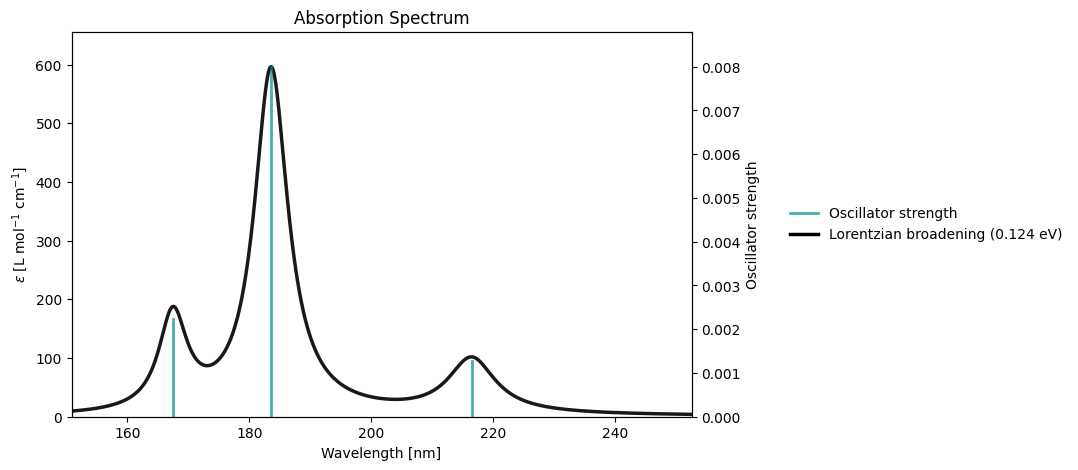

In [16]:
#@title Plot UV/Vis spectrum in nm
rpa_solver.plot_uv_vis(rpa_results)